In [1]:
import nltk
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict, Counter

import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

### Loading & viewing dataset.
- References [link_1](https://github.com/Nhan121/Kaggle-6-first-projects/blob/master/NLP_Text_Classification/NLP_Text_classification.ipynb)

In [2]:
path = r'../input/nlp-getting-started'
train = pd.read_csv(path + '/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test = pd.read_csv(path + '/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 1. Pre-processing
### 1.1. Counting & handling missing-values

In [4]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

#### Which type of these columns

In [5]:
pd.DataFrame({'count_NA': train.isna().sum(), 
              '%NA': round(100*train.isna().sum() / train.shape[0], 2), 
              'type' :train.dtypes})

,count_NA,%NA,type
id,0,0.00,int64
keyword,61,0.80,object
location,2533,33.27,object
text,0,0.00,object
target,0,0.00,int64


and for the `test.csv`

In [6]:
pd.DataFrame({'count_NA': test.isna().sum(), 
              '%NA': round(100*test.isna().sum() / test.shape[0], 2), 
              'type' :test.dtypes})

,count_NA,%NA,type
id,0,0.00,int64
keyword,26,0.80,object
location,1105,33.86,object
text,0,0.00,object


#### Comment.
- For the column `keyword`, it takes about `0.8%` at both dataset; whilethe column `location` is more than `33%`. Both of them (both columns) are the `object` types so we can replace the missing values by `unknown` to keep the structure preservation.
- The rest columns `id, text, target` (in `train.csv`) and `id, text` (in `test.csv`) has no missing value since we will predict the `target` (and add them to the `test`) mainly based on the `text`.

In [7]:
train = train.fillna('unknown')
test = test.fillna('unknown')
train.head()

,id,keyword,location,text,target
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1


### 1.2. Droping duplicated-values
#### The unique-values.

In [8]:
count_unique = [len(train[col].unique()) for col in train.columns]
percent_uniq = [round(100*cnt / train.shape[0], 2) for cnt in count_unique]
pd.DataFrame({'cnt_uniq': count_unique, 'perc_uniq_%': percent_uniq}, index = train.columns)

,cnt_uniq,perc_uniq_%
id,7613,100.00
keyword,222,2.92
location,3342,43.90
text,7503,98.56
target,2,0.03


#### Droping the duplicates values (after ignore the `id`)

In [9]:
train_non_id = train.drop(columns = ['id'])
train_non_id = train_non_id.drop_duplicates()
train_non_id.shape

(7561, 4)

### 1.3. Text-processing.

In [10]:
!pip install pyspellchecker

     |████████████████████████████████| 2.5 MB 902 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
import re
from spellchecker import SpellChecker    

def process_text(str_input):
    ## 1. Remove url_link
    remove_url = re.compile(r'https?://\S+|www\.\S+').sub(r'', str_input)
    
    ## 2. Remove html_link
    remove_html = re.compile(r'<.*?>').sub(r'', remove_url)
    
    ## 3. Remove Emojis
    remove_emo = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE).sub(r'', remove_html)
    words = re.sub(r"[^A-Za-z0-9\-]", " ", remove_emo).lower().split()    
        
    ## 4. spell_correction
    #spell = SpellChecker()
    #words = [spell.correction(word) for word in words[:50]]

    return words

## Review the first 5 lines after using text-processing
new_train = train.copy()
%time new_train.loc[:5, 'correct_text'] = train.loc[:5, 'text'].apply(lambda x: process_text(x))
new_train.head()

CPU times: user 14.1 ms, sys: 908 µs, total: 15 ms
Wall time: 14.8 ms


,id,keyword,location,text,target,correct_text
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1,"[13, 000, people, receive, wildfires, evacuati..."
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."


## 2. EDA.
Noting that, in the `train.csv`, we only have the `id` is the `integer` but it is used to assigned the index (it is not a `quantitative attribute`). Hence, we will only focus on the analysis the relation of the **Qualitative Attributes.**
### 2.1. Counting on the target.

Text(0, 0.5, 'samples')

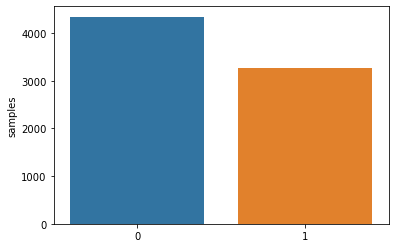

In [12]:
x = train.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

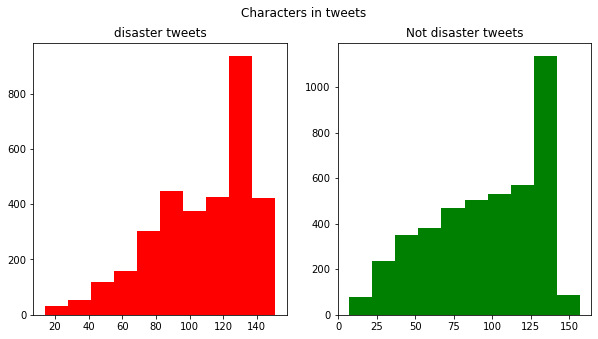

In [13]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10,5))
train_len = train[train['target'] == 1]['text'].str.len()
ax1.hist(train_len,color = 'red')
ax1.set_title('disaster tweets')
train_len = train[train['target'] == 0]['text'].str.len()
ax2.hist(train_len,color = 'green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

#### Number of word in each class.

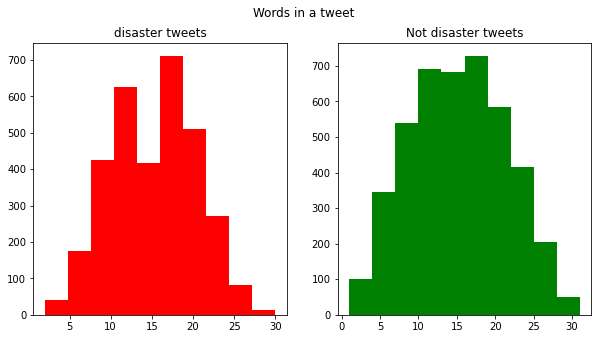

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
train_len = train[train['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color = 'red')
ax1.set_title('disaster tweets')
train_len = train[train['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color = 'green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

#### Average words length in tweet

Text(0.5, 0.98, 'Average word length in each tweet')

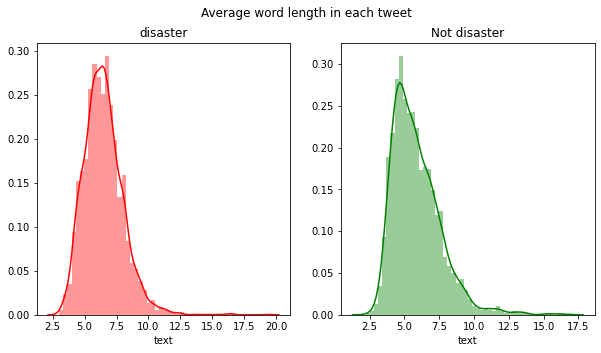

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
word = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color = 'red')
ax1.set_title('disaster')
word = train[train['target'] == 0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

#### "Location"

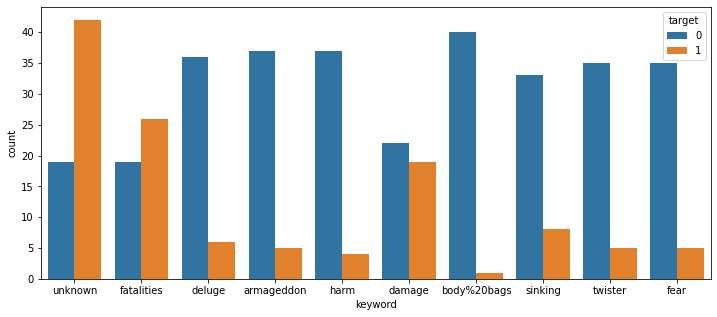

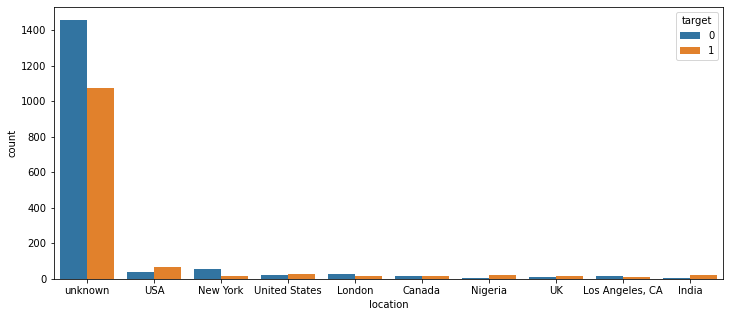

In [16]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.countplot(x = "keyword", 
              hue = "target", 
              data = train,
             order = train.keyword.value_counts().iloc[:10].index,
             ax = ax)

fig, ax = plt.subplots(figsize = (12, 5))
sns.countplot(x = "location", 
              hue = "target", 
              data = train,
             order = train.location.value_counts().iloc[:10].index,
             ax = ax)

### 2.2. Text-processing on the text-column

In [17]:
def create_corpus(target):
    corpus = []    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#### Common stopwords in tweets. First we will analyze tweets with

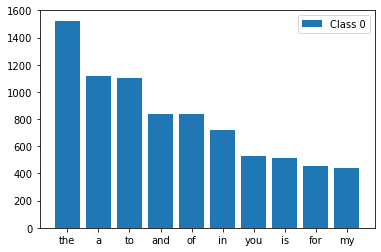

In [18]:
# For class 0.
corpus = create_corpus(0)
stop = set(stopwords.words('english'))
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1        
top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[ : 10]
#fig, ax = plt.subplots()
x,y = zip(*top)
plt.bar(x, y, label = 'Class 0')
plt.legend()

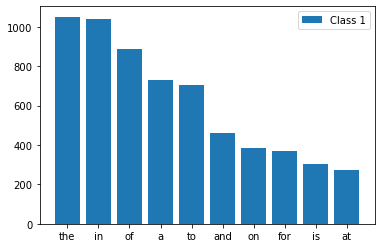

In [19]:
## For class 1
corpus = create_corpus(1)
dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1
top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[: 10]     

x, y = zip(*top)
plt.bar(x, y, label = 'Class 1')
plt.legend()
plt.show()

<BarContainer object of 20 artists>

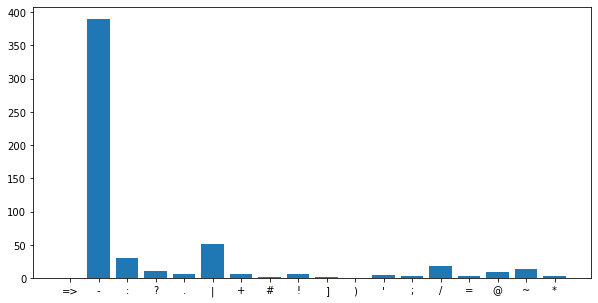

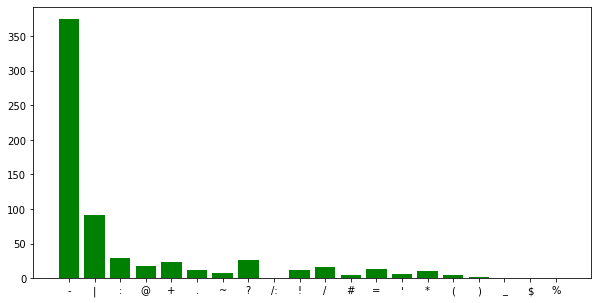

In [20]:
## Real disaster; class 1
plt.figure(figsize = (10,5))
corpus = create_corpus(1)
dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+= 1        
x,y = zip(*dic.items())
plt.bar(x, y)

## For class 0.
plt.figure(figsize = (10,5))
corpus = create_corpus(0)
dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+= 1
        
x, y = zip(*dic.items())
plt.bar(x ,y, color = 'green')

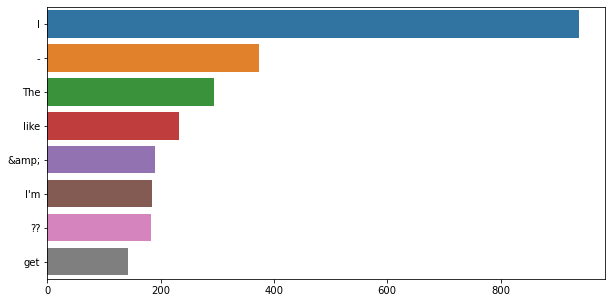

In [21]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word,count in most[: 40] :
    if (word not in stop) :
        x.append(word)
        y.append(count)
plt.figure(figsize = (10,5))        
sns.barplot(x = y, y = x)

## Ngram analysis
#### Firstly, We will do a bigram (n = 2) analysis over the tweets.Let's check the most common bigrams in tweets.


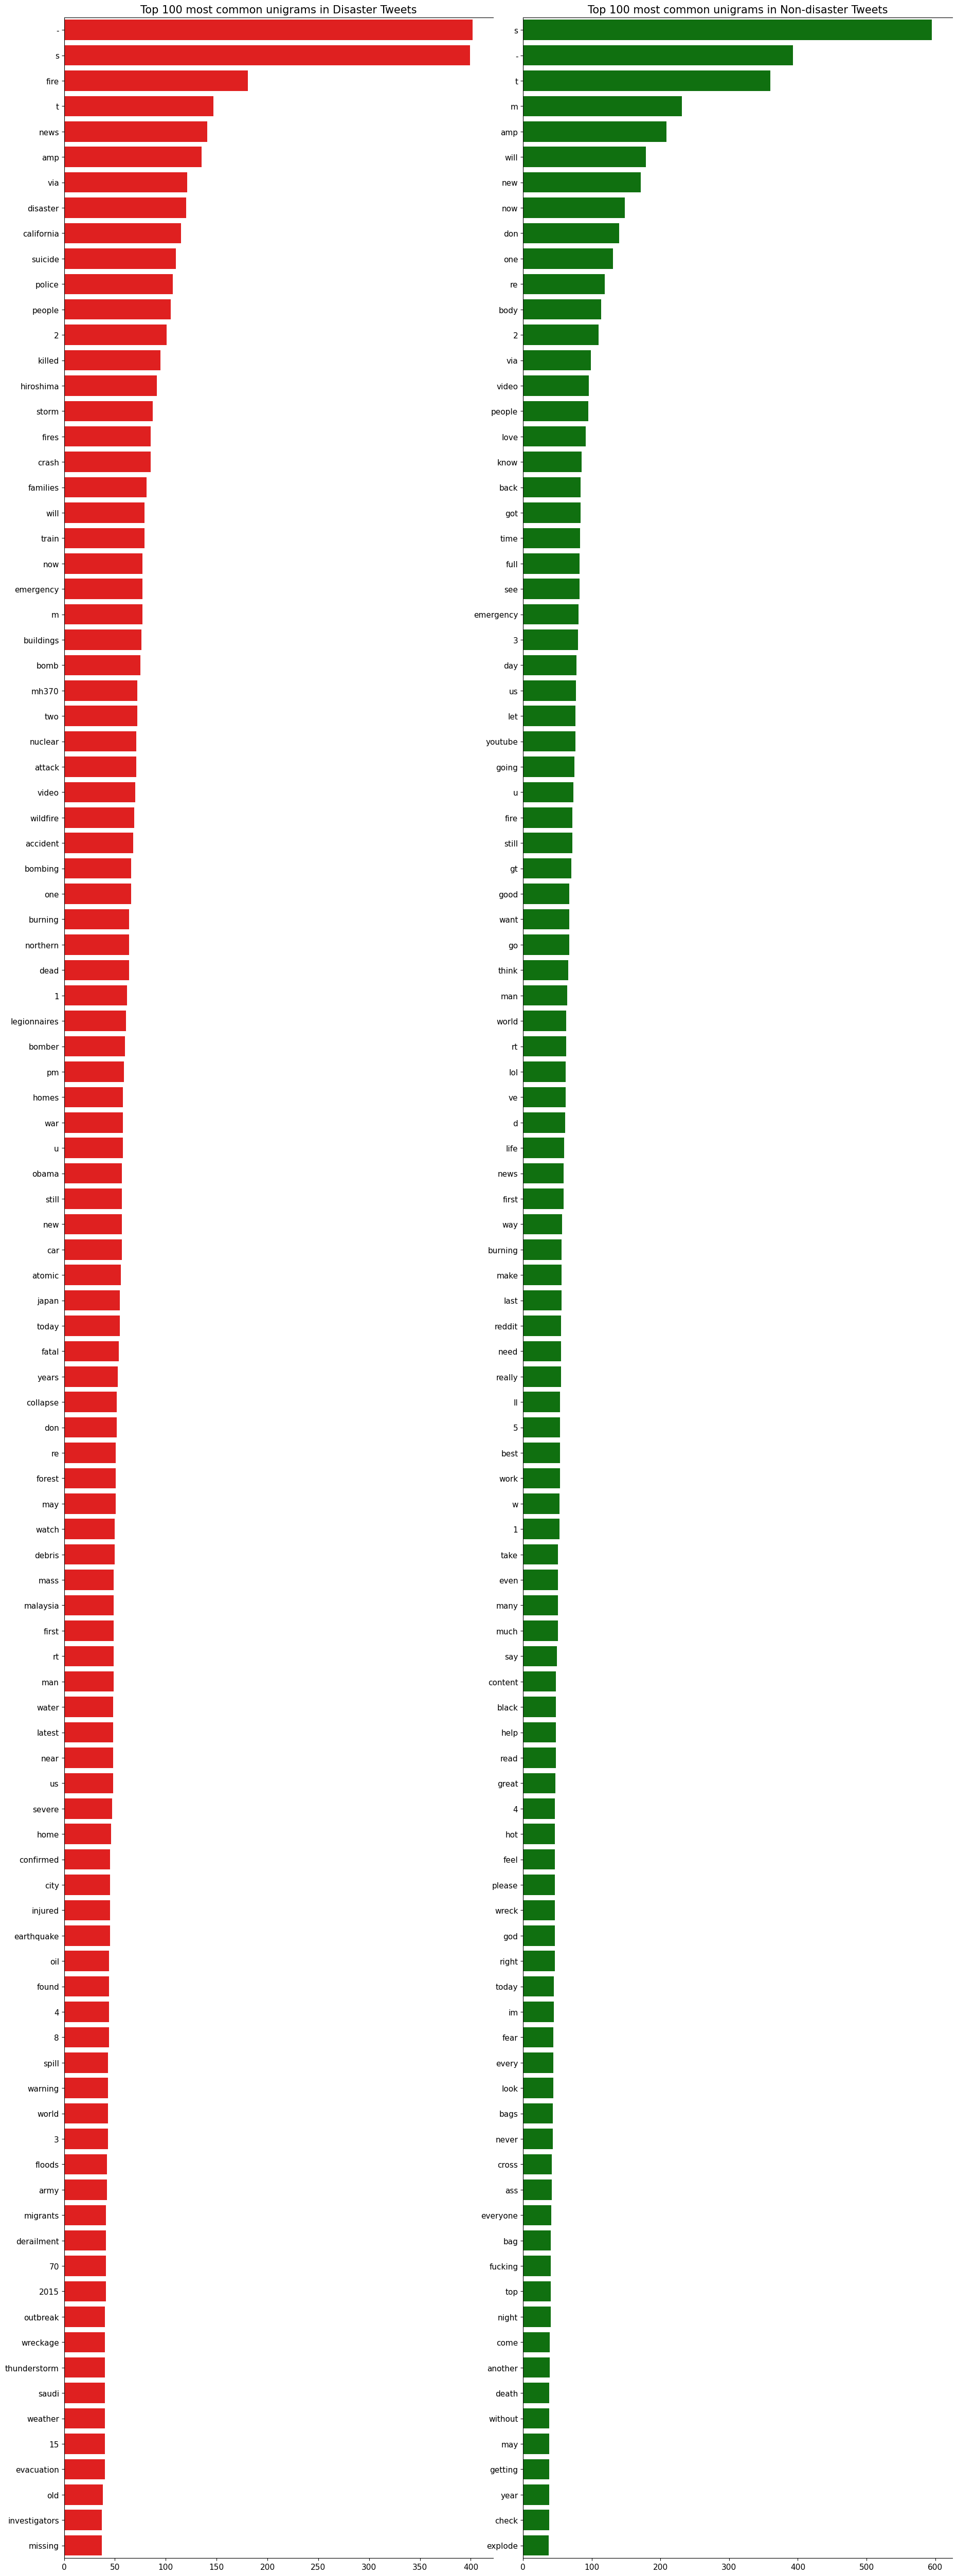

In [22]:
from wordcloud import STOPWORDS

N = 100
train['text'] = train['text'].apply(process_text)

DISASTER_TWEETS = train['target'] == 1

def generate_ngrams(text, n_gram=1):
    
    token = [token for token in text if token != '' if token not in STOPWORDS]
    
    ## if you don't apply the function process_text
    ## token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=11)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title('Top 100 most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title('Top 100 most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

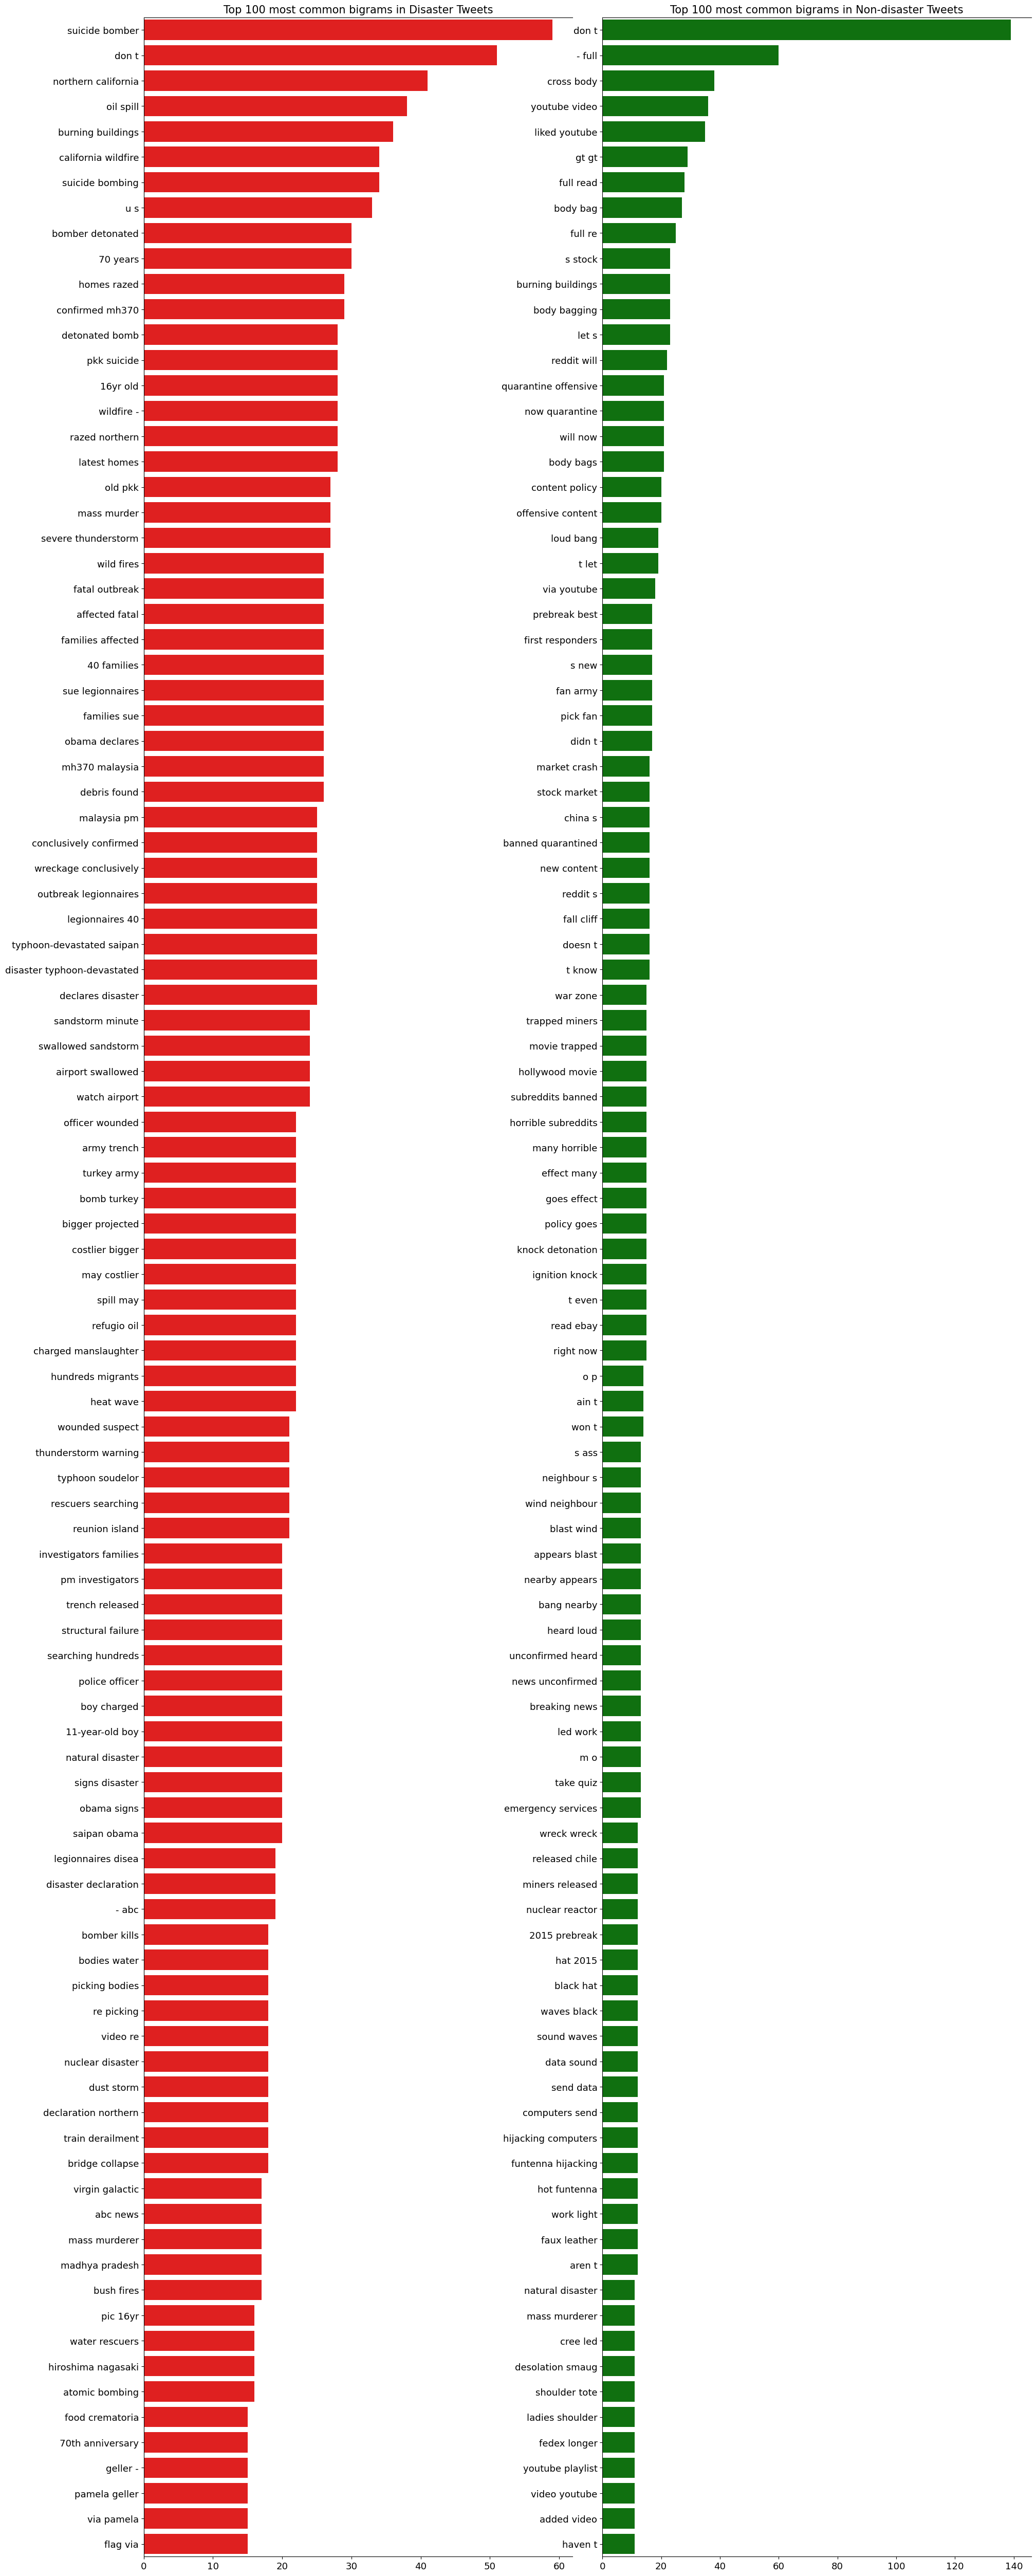

In [23]:
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

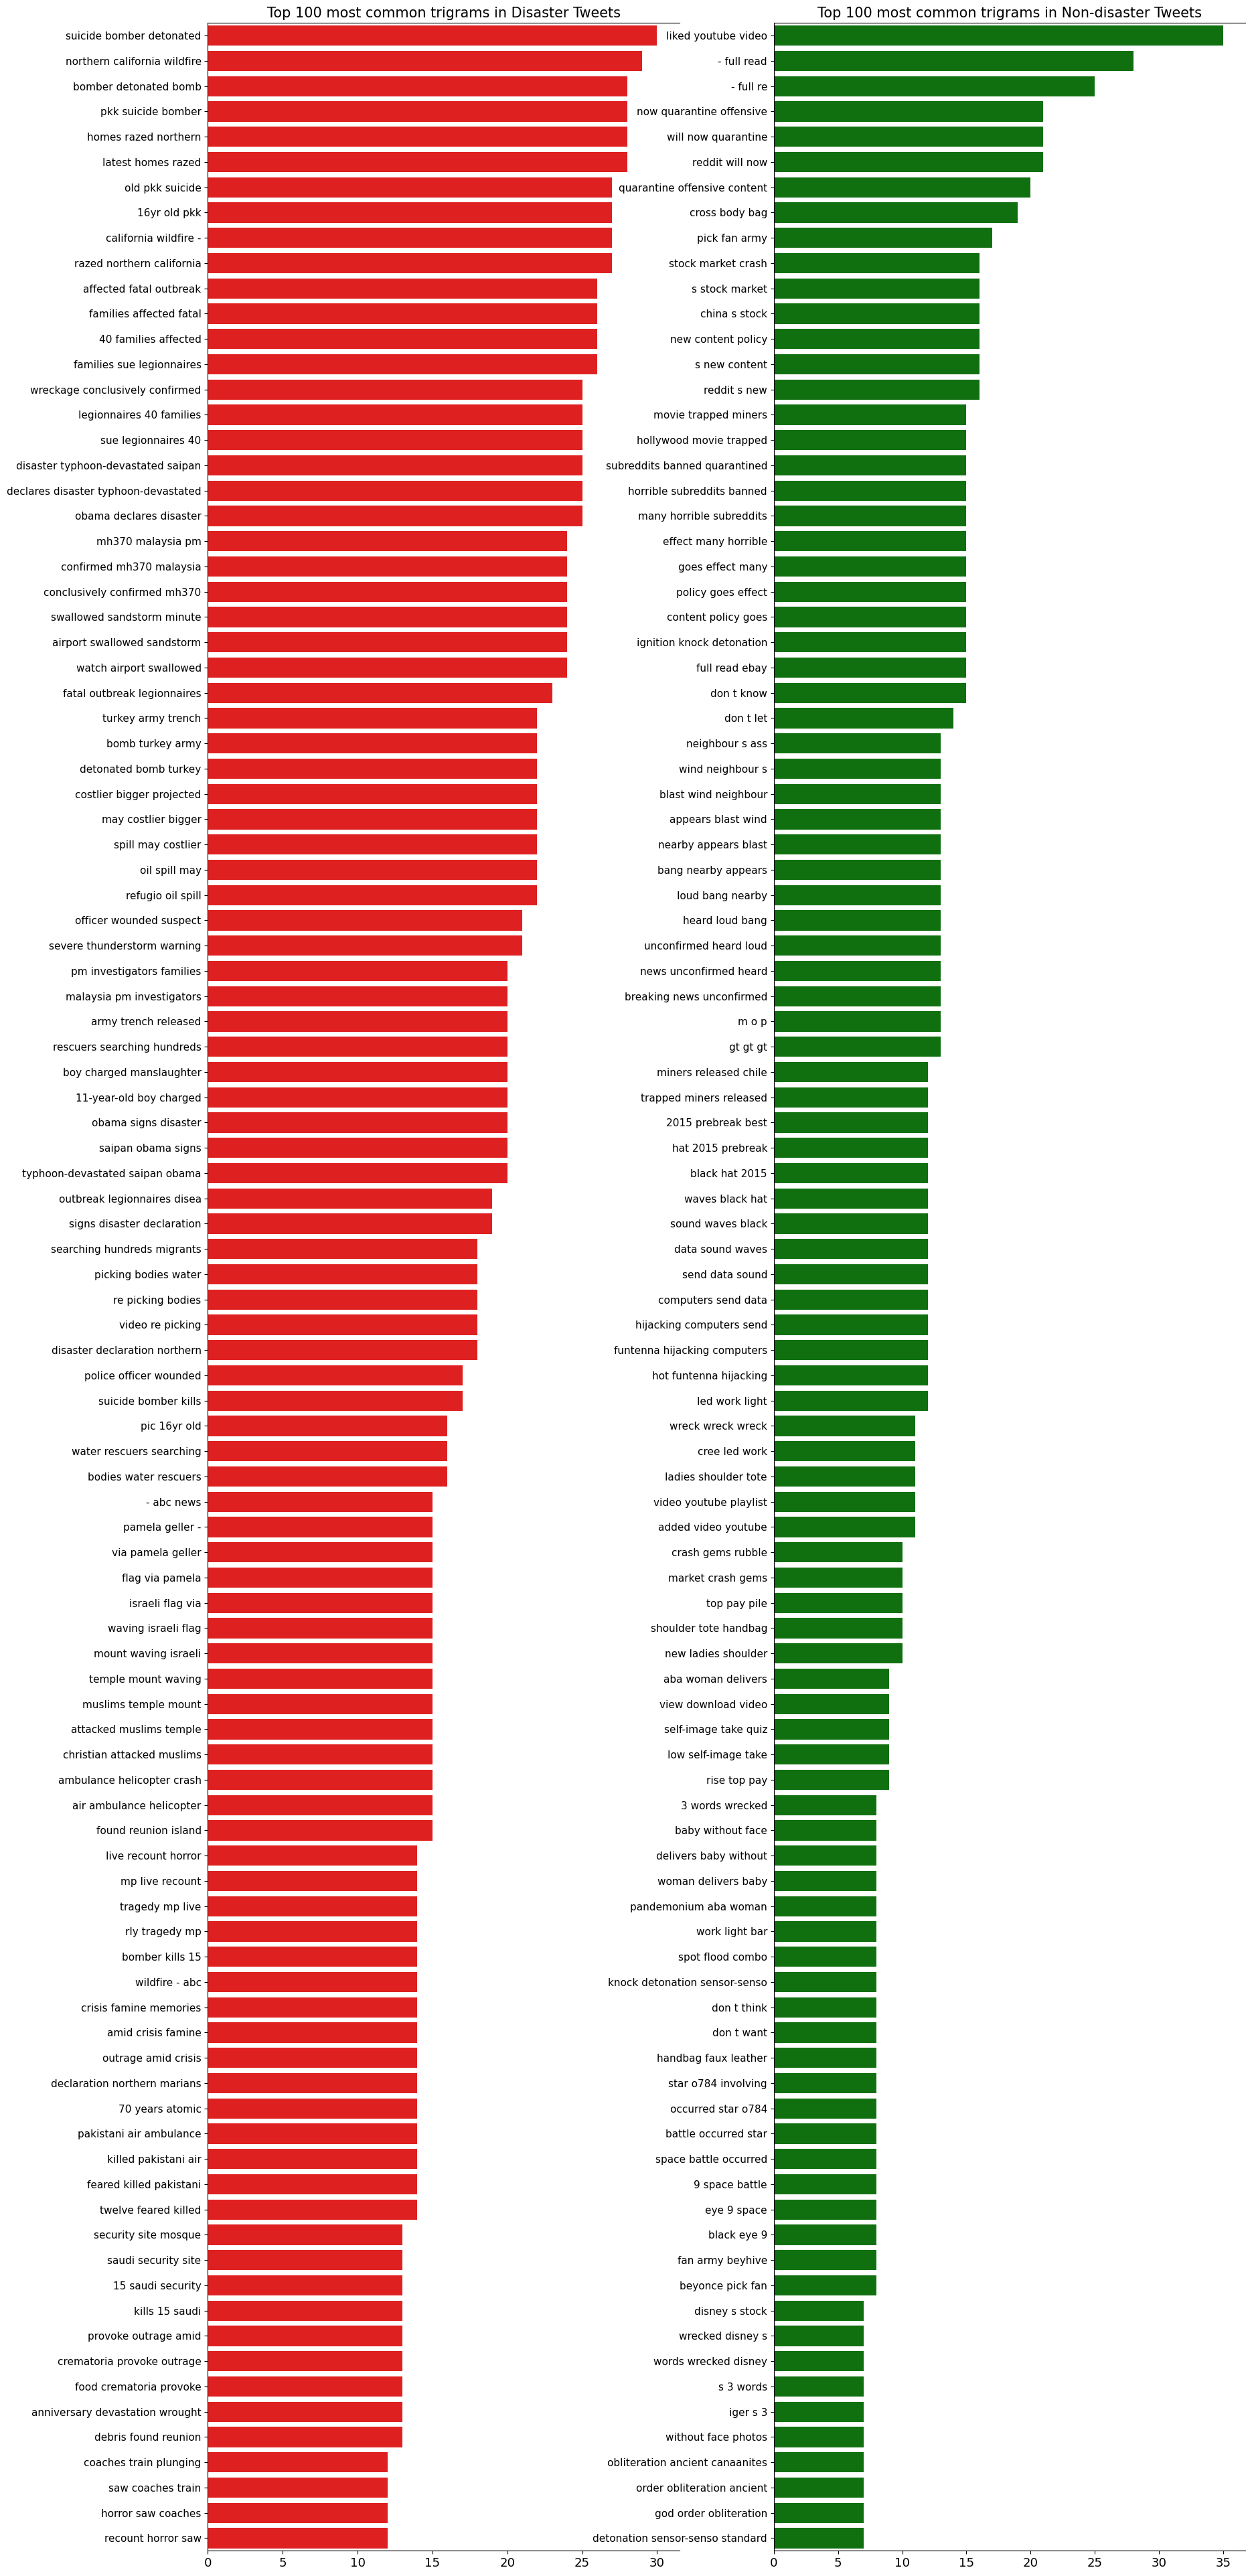

In [24]:
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()